In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
train_path = "multiple/Training"
test_path = "multiple/Testing"


In [4]:
IMAGE_SIZE = [128,128]

In [5]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=2,
                                            class_mode='categorical')

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [7]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [33]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# ResNet18

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.activations import relu
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import layers as Layers

In [15]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)


In [16]:
class Residual18(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [17]:
model5 = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[128, 128, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])

In [18]:
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model5.add(Residual18(filters, strides=strides))
    prev_filters = filters

In [19]:
model5.add(tf.keras.layers.GlobalAvgPool2D())
model5.add(tf.keras.layers.Flatten())
model5.add(tf.keras.layers.Dense(4, activation="softmax"))

In [20]:
model5.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

In [21]:
hist6 = model5.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/50
1435/1435 [==============================] - 37s 23ms/step - loss: 1.2585 - accuracy: 0.4934 - f1_m: 0.4388 - precision_m: 0.4969 - recall_m: 0.4098 - val_loss: 4.5784 - val_accuracy: 0.3147 - val_f1_m: 0.3147 - val_precision_m: 0.3147 - val_recall_m: 0.3147
Epoch 2/50
1435/1435 [==============================] - 32s 22ms/step - loss: 0.9081 - accuracy: 0.6303 - f1_m: 0.5916 - precision_m: 0.6439 - recall_m: 0.5655 - val_loss: 2.4785 - val_accuracy: 0.4822 - val_f1_m: 0.4391 - val_precision_m: 0.4594 - val_recall_m: 0.4289
Epoch 3/50
1435/1435 [==============================] - 32s 22ms/step - loss: 0.7504 - accuracy: 0.6927 - f1_m: 0.6719 - precision_m: 0.7181 - recall_m: 0.6488 - val_loss: 1.7958 - val_accuracy: 0.4619 - val_f1_m: 0.4552 - val_precision_m: 0.4822 - val_recall_m: 0.4416
Epoch 4/50
1435/1435 [==============================] - 32s 22ms/step - loss: 0.6917 - accuracy: 0.7185 - f1_m: 0.6992 - precision_m: 0.7373 - recall_m: 0.6801 - val_loss: 2.2914 - val_accur

In [22]:
res18_acc = hist6.history["val_accuracy"][25]
res18_prec = hist6.history["val_precision_m"][25]
res18_rec = hist6.history["val_recall_m"][25]
res18_f1 = hist6.history["val_f1_m"][25]

In [34]:
storeResults('ResNet18',res18_acc,res18_prec,res18_rec,res18_f1)

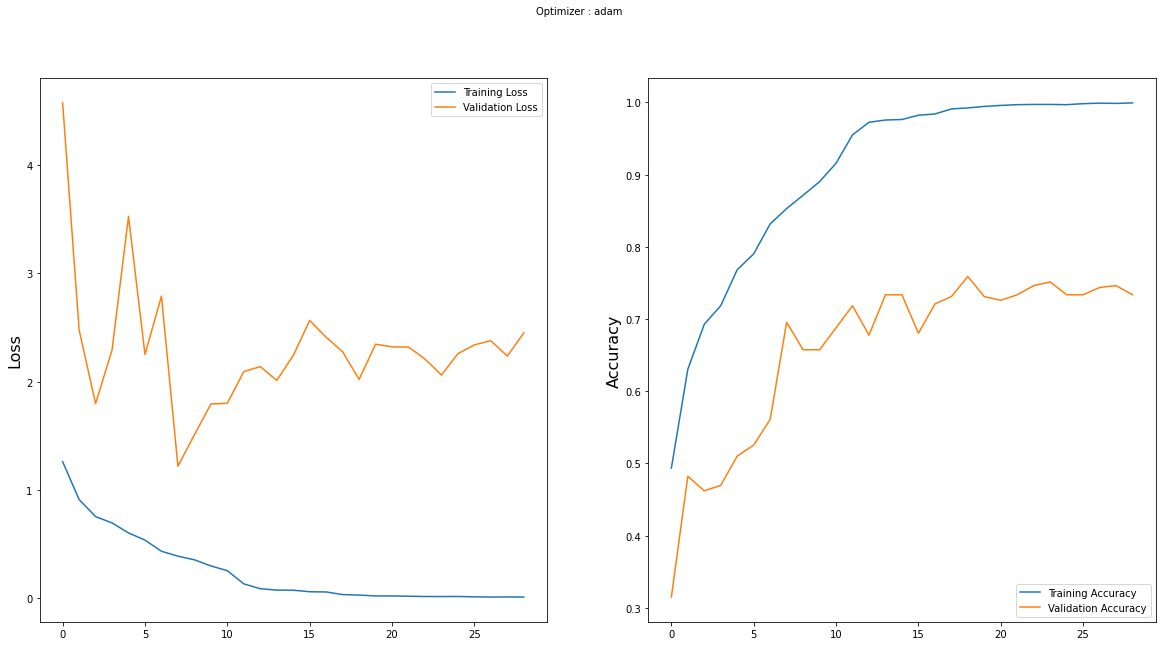

In [24]:
import matplotlib.pyplot as plt

x=hist6
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# ResNet34

In [25]:
class Residual34(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [26]:
model7 = tf.keras.Sequential([
    DefaultConv2D(128, kernel_size=7, strides=2, input_shape=[128, 128, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])

In [27]:
prev_filters = 128
for filters in [128] * 3 + [256] * 4 + [512] * 6 + [1024] * 3:
    strides = 1 if filters == prev_filters else 2
    model7.add(Residual34(filters, strides=strides))
    prev_filters = filters

In [28]:
model7.add(tf.keras.layers.GlobalAvgPool2D())
model7.add(tf.keras.layers.Flatten())
model7.add(tf.keras.layers.Dense(4, activation="softmax"))

In [29]:
model7.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

In [30]:
hist8 = model7.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/50
1435/1435 [==============================] - 41s 27ms/step - loss: 1.5009 - accuracy: 0.4652 - f1_m: 0.4199 - precision_m: 0.4693 - recall_m: 0.3951 - val_loss: 3.1916 - val_accuracy: 0.3401 - val_f1_m: 0.3384 - val_precision_m: 0.3452 - val_recall_m: 0.3350
Epoch 2/50
1435/1435 [==============================] - 38s 26ms/step - loss: 1.0665 - accuracy: 0.5756 - f1_m: 0.5482 - precision_m: 0.5937 - recall_m: 0.5254 - val_loss: 4.2973 - val_accuracy: 0.3426 - val_f1_m: 0.3333 - val_precision_m: 0.3350 - val_recall_m: 0.3325
Epoch 3/50
1435/1435 [==============================] - 38s 26ms/step - loss: 0.9079 - accuracy: 0.6359 - f1_m: 0.6129 - precision_m: 0.6533 - recall_m: 0.5927 - val_loss: 8.2011 - val_accuracy: 0.3528 - val_f1_m: 0.3452 - val_precision_m: 0.3503 - val_recall_m: 0.3426
Epoch 4/50
1435/1435 [==============================] - 38s 27ms/step - loss: 0.8330 - accuracy: 0.6603 - f1_m: 0.6401 - precision_m: 0.6882 - recall_m: 0.6160 - val_loss: 1.8922 - val_accur

Epoch 31/50
1435/1435 [==============================] - 38s 27ms/step - loss: 0.0080 - accuracy: 0.9979 - f1_m: 0.9979 - precision_m: 0.9979 - recall_m: 0.9979 - val_loss: 2.7515 - val_accuracy: 0.7259 - val_f1_m: 0.7267 - val_precision_m: 0.7284 - val_recall_m: 0.7259

Epoch 00031: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 32/50
1435/1435 [==============================] - 38s 26ms/step - loss: 0.0030 - accuracy: 0.9990 - f1_m: 0.9990 - precision_m: 0.9990 - recall_m: 0.9990 - val_loss: 2.7076 - val_accuracy: 0.7284 - val_f1_m: 0.7310 - val_precision_m: 0.7360 - val_recall_m: 0.7284
Epoch 33/50
1435/1435 [==============================] - 37s 26ms/step - loss: 0.0038 - accuracy: 0.9986 - f1_m: 0.9986 - precision_m: 0.9986 - recall_m: 0.9986 - val_loss: 2.5863 - val_accuracy: 0.7437 - val_f1_m: 0.7453 - val_precision_m: 0.7487 - val_recall_m: 0.7437
Epoch 34/50
1435/1435 [==============================] - 38s 26ms/step - loss: 0.0013 - accuracy: 1.0000 -

In [ ]:
res34_acc = hist8.history["val_accuracy"][47]
res34_prec = hist8.history["val_precision_m"][47]
res34_rec = hist8.history["val_recall_m"][47]
res34_f1 = hist8.history["val_f1_m"][47]

In [35]:
storeResults('ResNet34',res34_acc,res34_prec,res34_rec,res34_f1)

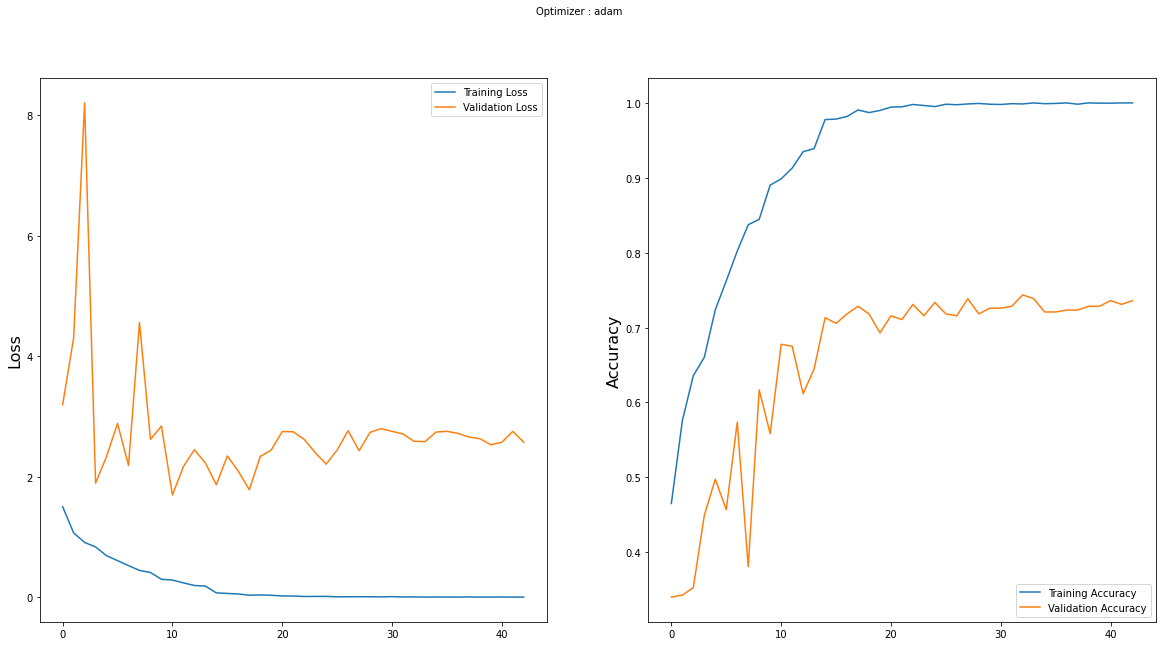

In [32]:
import matplotlib.pyplot as plt

x=hist8
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# DenseNet201

In [33]:
from tensorflow.keras.applications import DenseNet169, DenseNet201

In [34]:
des169=DenseNet169(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)
x1= Flatten()(des169.output)
prediction1 = Dense(4, activation='softmax')(x1)
model2 = Model(inputs = des169.inputs, outputs = prediction1)
model2.summary()
model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [36]:
hist2 = model2.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/50
1435/1435 [==============================] - 143s 95ms/step - loss: 3.8357 - accuracy: 0.3836 - f1_m: 0.3734 - precision_m: 0.3906 - recall_m: 0.3648 - val_loss: 45.6455 - val_accuracy: 0.3096 - val_f1_m: 0.3122 - val_precision_m: 0.3173 - val_recall_m: 0.3096
Epoch 2/50
1435/1435 [==============================] - 135s 94ms/step - loss: 1.7192 - accuracy: 0.5101 - f1_m: 0.4958 - precision_m: 0.5195 - recall_m: 0.4840 - val_loss: 5.4813 - val_accuracy: 0.3325 - val_f1_m: 0.3223 - val_precision_m: 0.3376 - val_recall_m: 0.3147
Epoch 3/50
1435/1435 [==============================] - 136s 95ms/step - loss: 1.4099 - accuracy: 0.5167 - f1_m: 0.4804 - precision_m: 0.5338 - recall_m: 0.4537 - val_loss: 2.4895 - val_accuracy: 0.3046 - val_f1_m: 0.2868 - val_precision_m: 0.3223 - val_recall_m: 0.2690
Epoch 4/50
1435/1435 [==============================] - 136s 95ms/step - loss: 0.9624 - accuracy: 0.5899 - f1_m: 0.5443 - precision_m: 0.6084 - recall_m: 0.5122 - val_loss: 23.8127 - val

In [ ]:
dense_acc = hist2.history["val_accuracy"][32]
dense_prec = hist2.history["val_precision_m"][32]
dense_rec = hist2.history["val_recall_m"][32]
dense_f1 = hist2.history["val_f1_m"][32]

In [36]:
storeResults('DenseNet201',dense_acc,dense_prec,dense_rec,dense_f1)

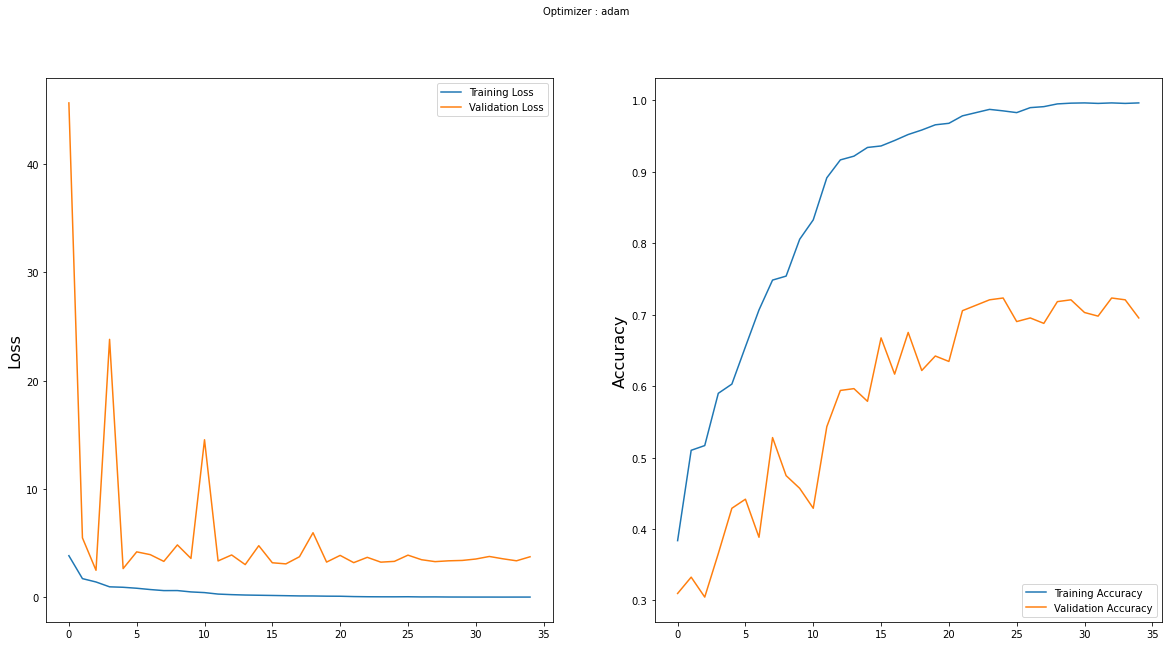

In [37]:
import matplotlib.pyplot as plt

x=hist2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Xception

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

In [9]:
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(4, activation='softmax')(x)
# Combining base and head 
model1 = Model(inputs=base.input, outputs=head)

In [10]:
model1.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])

In [11]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [12]:
hist1 = model1.fit(test_set, validation_data=test_set, epochs=50, steps_per_epoch=len(test_set), validation_steps=len(test_set))

Epoch 1/50
197/197 [==============================] - 14s 37ms/step - loss: 1.3637 - accuracy: 0.2944 - f1_m: 0.0440 - precision_m: 0.0660 - recall_m: 0.0330 - val_loss: 1.5519 - val_accuracy: 0.2259 - val_f1_m: 0.0745 - val_precision_m: 0.1015 - val_recall_m: 0.0609
Epoch 2/50
197/197 [==============================] - 7s 34ms/step - loss: 1.2587 - accuracy: 0.4086 - f1_m: 0.1286 - precision_m: 0.1878 - recall_m: 0.0990 - val_loss: 1.2281 - val_accuracy: 0.4924 - val_f1_m: 0.0863 - val_precision_m: 0.1269 - val_recall_m: 0.0660
Epoch 3/50
197/197 [==============================] - 6s 33ms/step - loss: 1.1432 - accuracy: 0.5203 - f1_m: 0.2453 - precision_m: 0.3401 - recall_m: 0.1980 - val_loss: 1.1189 - val_accuracy: 0.5431 - val_f1_m: 0.1912 - val_precision_m: 0.2741 - val_recall_m: 0.1497
Epoch 4/50
197/197 [==============================] - 7s 35ms/step - loss: 1.0587 - accuracy: 0.5635 - f1_m: 0.3452 - precision_m: 0.4569 - recall_m: 0.2893 - val_loss: 1.0501 - val_accuracy: 0.6142

Epoch 32/50
197/197 [==============================] - 7s 34ms/step - loss: 0.0508 - accuracy: 0.9898 - f1_m: 0.9873 - precision_m: 0.9924 - recall_m: 0.9848 - val_loss: 0.0192 - val_accuracy: 0.9975 - val_f1_m: 0.9924 - val_precision_m: 0.9975 - val_recall_m: 0.9898
Epoch 33/50
197/197 [==============================] - 7s 34ms/step - loss: 0.0223 - accuracy: 0.9949 - f1_m: 0.9958 - precision_m: 0.9975 - recall_m: 0.9949 - val_loss: 0.0135 - val_accuracy: 0.9975 - val_f1_m: 0.9983 - val_precision_m: 1.0000 - val_recall_m: 0.9975
Epoch 34/50
197/197 [==============================] - 7s 34ms/step - loss: 0.0265 - accuracy: 0.9924 - f1_m: 0.9924 - precision_m: 0.9924 - recall_m: 0.9924 - val_loss: 0.0412 - val_accuracy: 0.9924 - val_f1_m: 0.9907 - val_precision_m: 0.9924 - val_recall_m: 0.9898
Epoch 35/50
197/197 [==============================] - 7s 34ms/step - loss: 0.0237 - accuracy: 0.9949 - f1_m: 0.9958 - precision_m: 0.9975 - recall_m: 0.9949 - val_loss: 0.0198 - val_accuracy: 0.9

In [37]:
xec_acc = hist1.history["val_accuracy"][49]
xec_prec = hist1.history["val_precision_m"][49]
xec_rec = hist1.history["val_recall_m"][49]
xec_f1 = hist1.history["val_f1_m"][49]

In [38]:
storeResults('Xception',xec_acc,xec_prec,xec_rec,xec_f1)

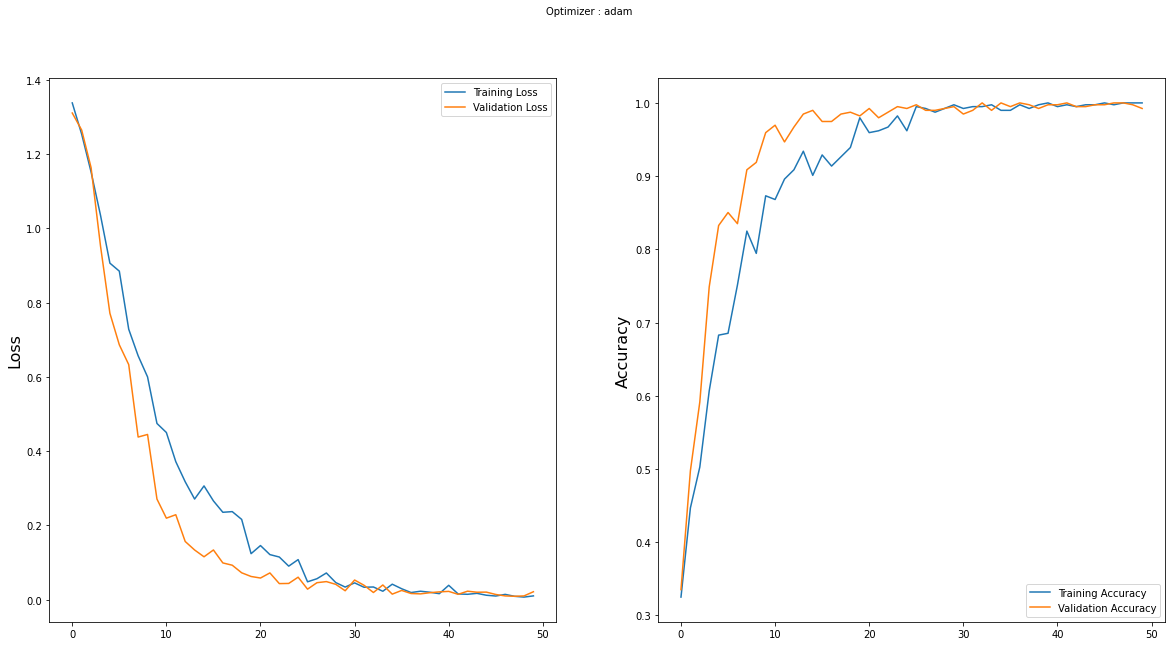

In [43]:
import matplotlib.pyplot as plt

x=hist1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# ResNet50 - backbone of SSCLNet

In [14]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
IMGSIZE = 128
transform1 = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(0.2),
                                transforms.ToTensor(),
                                transforms.Resize((IMGSIZE,IMGSIZE))
                               ])

In [17]:
full_data = torchvision.datasets.ImageFolder(root = 'multiple/Training', transform = transform1)

In [18]:
classes = full_data.classes
print("Classes:",classes)
num_classes = len(full_data.classes)
print("Number of Classes:",num_classes)

Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Number of Classes: 4


In [19]:
train_data, test_data = torch.utils.data.random_split(full_data, [2000, 870])

In [20]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 46, shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 46, shuffle = True)

In [21]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

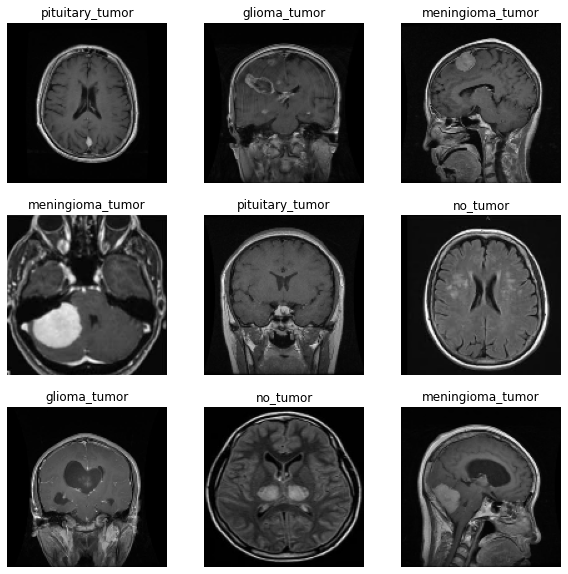

In [22]:
N_IMAGES = 9

images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])

classes = full_data.classes

plot_images(images, labels, classes)

In [23]:
model9 = models.resnet50(pretrained=True)

In [24]:
print(model9)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
q = model9.fc.in_features
model9.fc = nn.Linear(q, num_classes)

model9 = model9.cpu()

In [26]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(model9.parameters(),lr=1e-5,weight_decay=1e-5)

In [27]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 5

In [28]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        model9.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model9(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()
        
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        model9.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = model9(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 0.68;   Train Accuracy : 57.20%;   Test Loss : 0.87;   Test Accuracy : 76.55%
Epoch 2 =>  Train Loss : 0.43;   Train Accuracy : 85.15%;   Test Loss : 0.57;   Test Accuracy : 85.17%
Epoch 3 =>  Train Loss : 0.23;   Train Accuracy : 90.75%;   Test Loss : 0.38;   Test Accuracy : 89.66%
Epoch 4 =>  Train Loss : 0.16;   Train Accuracy : 93.80%;   Test Loss : 0.17;   Test Accuracy : 92.30%
Epoch 5 =>  Train Loss : 0.18;   Train Accuracy : 96.80%;   Test Loss : 0.15;   Test Accuracy : 92.07%


In [29]:
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

In [30]:
model9.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        #images = criter(outputs, labels).to(device)
        outputs = model9(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

In [31]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [32]:
sevrnet_acc = accuracy_score(y_label, y_predict)
sevrnet_prec = precision_score(y_label, y_predict,average='weighted')
sevrnet_rec = recall_score(y_label, y_predict,average='weighted')
sevrnet_f1 = f1_score(y_label, y_predict,average='weighted')

In [39]:
storeResults('SSCLNet backbone of ResNet50',sevrnet_acc,sevrnet_prec,sevrnet_rec,sevrnet_f1)

In [65]:
# Save the model checkpoint
#torch.save(googlenet.state_dict(), 'GoogleNetModel.ckpt')
torch.save(model9.state_dict(), 'resnet50.pth')

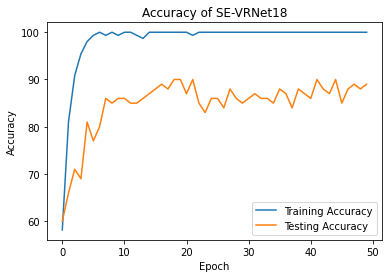

In [66]:
plt.plot(range(50),TrainAcc)
plt.plot(range(50),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of SE-VRNet18")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

# Comparison

In [40]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'Recall'   : recall, 
                       'F1_score' : f1score,
                        
                        
                      })

In [41]:
result

,ML Model,Accuracy,Precision,Recall,F1_score
0,ResNet18,0.734,0.737,0.744,0.734
1,ResNet34,0.736,0.736,0.736,0.736
2,DenseNet201,0.695,0.695,0.695,0.695
3,Xception,1.000,1.000,1.000,1.000
4,SSCLNet backbone of ResNet50,0.928,0.928,0.928,0.928


# MOdelling

In [42]:
model1.save('model_multi.h5')

# Graph

In [43]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

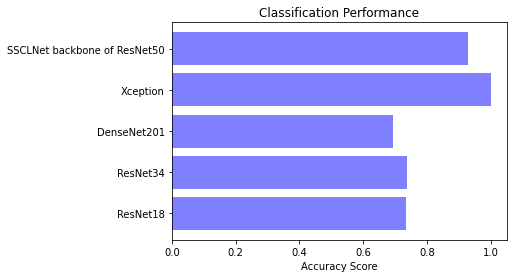

In [44]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

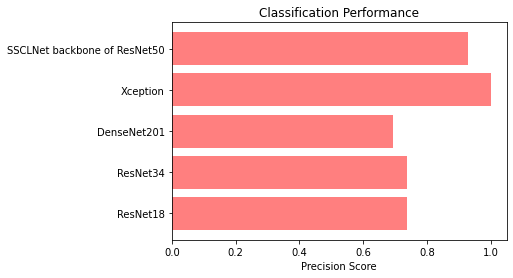

In [45]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

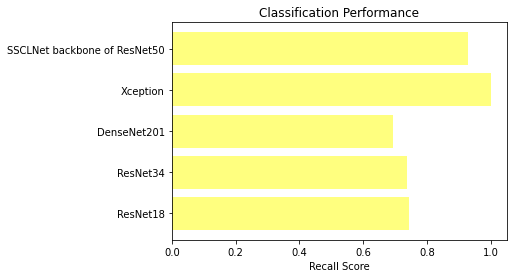

In [46]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 SCore

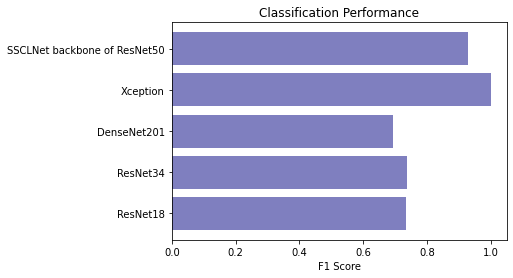

In [47]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()